## Import libraries


In [1]:
import vco
import numpy as np
import numpy.ma as ma
import numpy.random as nprd
import matplotlib.pyplot as plt
from scipy.integrate             import trapz
from scipy.signal                import correlate2d
from scipy.ndimage.interpolation import rotate
from __future__ import absolute_import, division, print_function

%matplotlib inline


## Create VCO matrix


In [2]:
numrow, numcol = 6, 12
ringsize = 12
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(numrow)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(numcol))/numcol
phz_noise = 0

VCOmat = [[vco.VCO_model(ringsize, rhos[i], thetas[j], phz_noise) \
           for j in range(numcol)] for i in range(numrow)]

## Create 1000 random weight matrices following grid cell algorithm

In [6]:
n_inputs = 3
n_mats = 1000
rd_wts = np.full([numrow,numcol,n_mats], np.nan)

for mat in range(n_mats):
    random_row = nprd.randint(numrow)
    random_cols = np.arange(numcol)
    nprd.shuffle(random_cols)

    for col in random_cols[:n_inputs]:
        rd_wts[random_row, col, mat] = nprd.randint(ringsize)

## Compute outputs for random grid cells with theta_to_grid (multiplicative)

In [7]:
size = 10
rd_outputs = np.zeros((10*size, 10*size, n_mats, 2))
for i in range(n_mats):
    norm_env, env_prod = vco.theta_to_grid(VCOmat, rd_wts[:,:,i], size)
    rd_outputs[:,:,i,0] = norm_env
    rd_outputs[:,:,i,1] = env_prod

## Plot random grid cells (product, not norm)

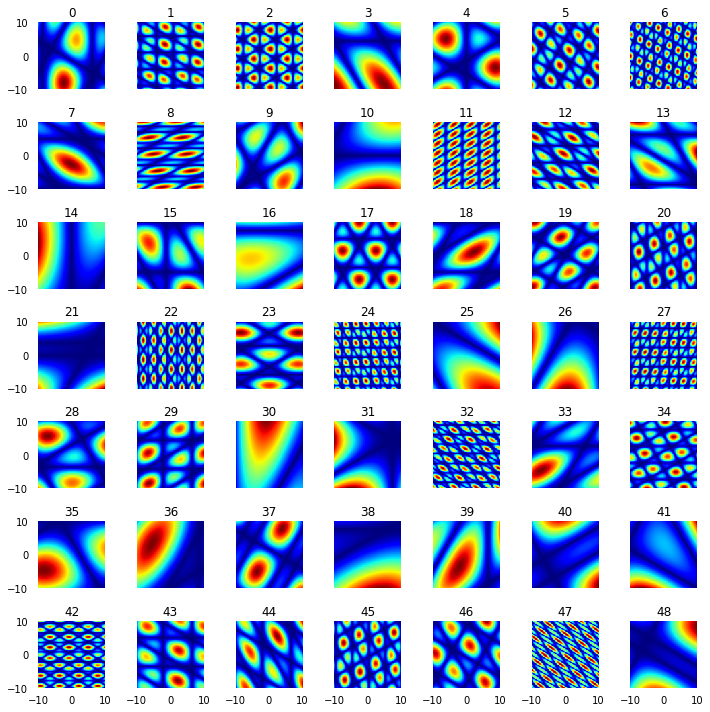

In [8]:
fig, axes = plt.subplots(nrows=7, ncols=7, sharex=True, sharey=True, figsize=(10,10))
axes_list = [item for sublist in axes for item in sublist]

for idx in range(49):
    ax = axes_list.pop(0)
    ax.imshow(rd_outputs[:,:,idx,1],cmap='jet',extent=(-size,size,-size,size))
    ax.set_title(idx)
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

for ax in axes_list:
    ax.remove()

plt.tight_layout()

## Prune non-maximal grid cells from population (N=1000)

In [9]:
mx = np.max(rd_outputs)
th = 0.9

mask = np.ones(n_mats,dtype=bool)
for gc in range(n_mats):
    if (np.max(rd_outputs[:,:,gc,1]) < th*mx):
        mask[[gc]] = False
rd_out_pruned = rd_outputs[:,:,mask,:]
rd_wts_pruned = rd_wts[:,:,mask]
print("Threshold value: {}".format(th))
print("Pruned population size: {}".format(rd_out_pruned.shape))
print("Pruned weight matrix size: {}".format(rd_wts_pruned.shape))

Threshold value: 0.9
Pruned population size: (100, 100, 616, 2)
Pruned weight matrix size: (6, 12, 616)


## Plot pruned outputs

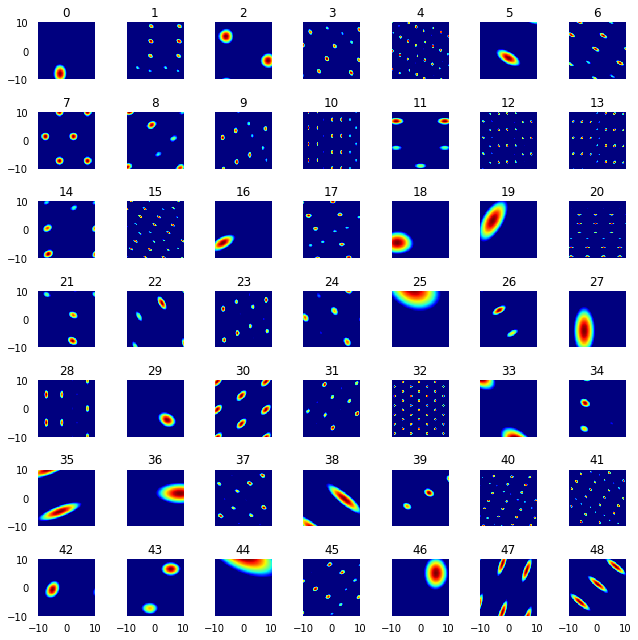

In [10]:
fig, axes = plt.subplots(nrows=7, ncols=7, sharex=True, sharey=True, figsize=(9,9))
axes_list = [item for sublist in axes for item in sublist]

for idx in range(49):
    ax = axes_list.pop(0)
    ax.imshow(rd_out_pruned[:,:,idx,0],cmap='jet',extent=(-size,size,-size,size))
    ax.set_title(idx)
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

for ax in axes_list:
    ax.remove()

plt.tight_layout()

## Compare numbers of pruned grid cells by row (rho)

In [12]:
row5a = np.count_nonzero(~np.isnan(rd_wts[5,:,:]))/3
row4a = np.count_nonzero(~np.isnan(rd_wts[4,:,:]))/3
row3a = np.count_nonzero(~np.isnan(rd_wts[3,:,:]))/3
row2a = np.count_nonzero(~np.isnan(rd_wts[2,:,:]))/3
row1a = np.count_nonzero(~np.isnan(rd_wts[1,:,:]))/3
row0a = np.count_nonzero(~np.isnan(rd_wts[0,:,:]))/3
print("ORIGINAL\nrow5: {}, row4: {}, row3: {}, row2: {}, row1: {}, row0: {}".format(row5a,row4a,row3a,row2a,row1a,row0a))

row5 = np.count_nonzero(~np.isnan(rd_wts_pruned[5,:,:]))/3
row4 = np.count_nonzero(~np.isnan(rd_wts_pruned[4,:,:]))/3
row3 = np.count_nonzero(~np.isnan(rd_wts_pruned[3,:,:]))/3
row2 = np.count_nonzero(~np.isnan(rd_wts_pruned[2,:,:]))/3
row1 = np.count_nonzero(~np.isnan(rd_wts_pruned[1,:,:]))/3
row0 = np.count_nonzero(~np.isnan(rd_wts_pruned[0,:,:]))/3
print("PRUNED\nrow5: {}, row4: {}, row3: {}, row2: {}, row1: {}, row0: {}".format(row5,row4,row3,row2,row1,row0))


ORIGINAL
row5: 165.0, row4: 171.0, row3: 185.0, row2: 166.0, row1: 165.0, row0: 148.0
PRUNED
row5: 134.0, row4: 142.0, row3: 149.0, row2: 106.0, row1: 64.0, row0: 21.0


## Re-test using grid cells only in row 3

In [13]:
n_inputs = 3
n_mats = 1000
r3_wts = np.full([numrow,numcol,n_mats], np.nan)

for mat in range(n_mats):
    chosen_row = 3
    random_cols = np.arange(numcol)
    nprd.shuffle(random_cols)

    for col in random_cols[:n_inputs]:
        r3_wts[chosen_row, col, mat] = nprd.randint(ringsize)

size = 10
r3_outputs = np.zeros((10*size, 10*size, n_mats, 2))
for i in range(n_mats):
    norm_env, env_prod = vco.theta_to_grid(VCOmat, r3_wts[:,:,i], size)
    r3_outputs[:,:,i,0] = norm_env
    r3_outputs[:,:,i,1] = env_prod


## Plot row 3 random grid cells

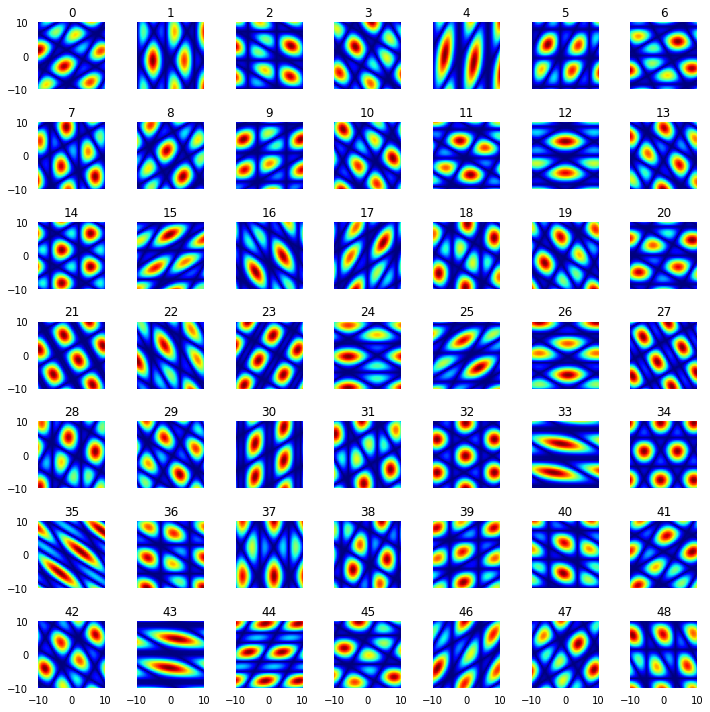

In [14]:
fig, axes = plt.subplots(nrows=7, ncols=7, sharex=True, sharey=True, figsize=(10,10))
axes_list = [item for sublist in axes for item in sublist]

for idx in range(49):
    ax = axes_list.pop(0)
    ax.imshow(r3_outputs[:,:,idx,1],cmap='jet',extent=(-size,size,-size,size))
    ax.set_title(idx)
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

for ax in axes_list:
    ax.remove()

plt.tight_layout()

## Pruning with same method the row 3 grid cell population

In [17]:
mx3 = np.max(r3_outputs)
mask3 = np.ones(n_mats,dtype=bool)
for gc in range(n_mats):
    if (np.max(rd_outputs[:,:,gc,1]) < th*mx3):
        mask3[[gc]] = False
r3_out_pruned = r3_outputs[:,:,mask3,:]
r3_wts_pruned = r3_wts[:,:,mask]

print("Threshold value: {}".format(th))
print("Pruned population size: {}".format(r3_out_pruned.shape))
print("Pruned weight matrix size: {}".format(r3_wts_pruned.shape))

Threshold value: 0.9
Pruned population size: (100, 100, 616, 2)
Pruned weight matrix size: (6, 12, 616)


## Testing single cell's response to get_env_mult


Minimum: 0.000437333237621
Maximum: 1.99999998919


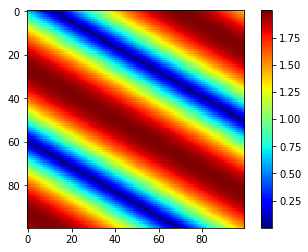

In [18]:
testVCO = vco.VCO_model(6, 0.54, np.pi/3.0, 0)
ss = np.linspace(-10,10,100)
xx, yy = np.meshgrid(ss,ss)
response = testVCO.get_envelope(5,xx,yy,1)

plt.imshow((np.abs(response)),cmap='jet');  plt.colorbar()

print("Minimum:",np.min(np.abs(response)))
print("Maximum:",np.max(np.abs(response)))

## Gridness scoring


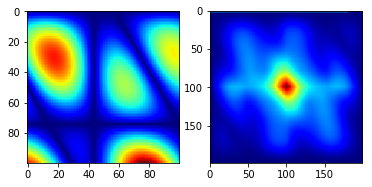

In [19]:
tester = rd_outputs[:,:,15,1]; plt.imshow(tester,cmap='jet')
autocorr = correlate2d(tester,tester,mode='full')
plt.subplot(121)
plt.imshow(tester,cmap='jet')
plt.subplot(122)
plt.imshow(autocorr,cmap='jet')

angles = list(range(0,183,3))
crossCorr = []
for angle in angles:
    autoCorrRot = rotate(autocorr, angle,reshape=False)
    C = np.corrcoef(np.reshape(autocorr, (1, autocorr.size)),
        np.reshape(autoCorrRot, (1, autoCorrRot.size)))
    crossCorr.append(C[0, 1])

max_angles_i = np.array([30/3, 90/3, 150/3],dtype=int)
min_angles_i = np.array([60/3, 120/3],dtype=int)

maxima = np.max(np.array(crossCorr)[max_angles_i])
minima = np.min(np.array(crossCorr)[min_angles_i])
G = minima - maxima

crossCorr = np.array(crossCorr)
plt.plot(angles,crossCorr)

## Trying the other

In [21]:
numrow, numcol = 6, 12
ringsize = 12
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(numrow)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(numcol))/numcol
phz_noise = 0

VCOmat = [[vco.VCO_model(ringsize, rhos[i], thetas[j], phz_noise) \
           for j in range(numcol)] for i in range(numrow)]

## Create many grid cells:
For each row, all column combos, all cell combos:
6 rows x 4 column combos (12/3) x 12^3 cell combos (~41k grid cells)

In [23]:
full_matrix = np.full([6,12,6*4*12**3], np.nan)
jdx = 0
for row in range(6):
    for firstcol in range(4):
        for cell1 in range(12):
            for cell2 in range(12):
                for cell3 in range(12):
                    full_matrix[row,firstcol,  jdx] = cell1
                    full_matrix[row,firstcol+4,jdx] = cell2
                    full_matrix[row,firstcol+8,jdx] = cell3
                    jdx = jdx + 1

## 100 random projections of num_gc grid cells to create potential place cells

In [25]:
num_gc = 40
size   = 5
num_pc = 100

pc_wts = np.zeros([6,12,num_gc,num_pc])
pc_outputs = np.zeros([size*10,size*10,num_pc])
gc_outputs = np.zeros([size*10,size*10,num_gc,num_pc])
for pc in range(num_pc):
    rd_idx = nprd.randint(0,full_matrix.shape[2],size=num_gc)
    pc_wts[:,:,:,pc] = full_matrix[:,:,rd_idx]

    for gc in range(num_gc):
        #gc_norm, gc_env = vco.theta_to_grid(VCOmat, pc_wts[:,:,gc,pc], size)
        gc_norm, gc_env = vco.theta_to_hcn(VCOmat, pc_wts[:,:,gc,pc], size)
        gc_outputs[:,:,gc,pc] = gc_norm
    pc_outputs[:,:,pc] = np.sum(gc_outputs[:,:,:,pc],axis=2)

In [26]:
## ?

G=0.27098565410507625


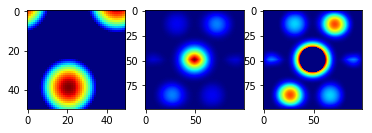

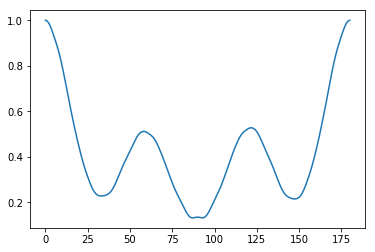

In [27]:
tester = gc_outputs[:,:,0,12]
#plt.imshow(gc_outputs[:,:,0,12],cmap='jet')
autocorr = correlate2d(tester,tester)
plt.figure()
plt.subplot(131)
plt.imshow(tester,cmap='jet')
plt.subplot(132)
plt.imshow(autocorr,cmap='jet')
xc, yc, r = 49, 49, 13
x, y = np.meshgrid(np.arange(99), np.arange(99))
d2 = (x - xc)**2 + (y - yc)**2
mask = d2 < r**2
autocorr[mask] = 0
plt.subplot(133)
plt.imshow(autocorr,cmap='jet')

dAng = 1

angles = list(range(0,180+dAng,dAng))
crossCorr = []
for angle in angles:
    autoCorrRot = rotate(autocorr, angle,reshape=False)
    C = np.corrcoef(np.reshape(autocorr, (1, autocorr.size)),
        np.reshape(autoCorrRot, (1, autoCorrRot.size)))
    crossCorr.append(C[0, 1])


max_angles_i = np.array([30/dAng, 90/dAng, 150/dAng],dtype=int)
min_angles_i = np.array([60/dAng, 120/dAng],dtype=int)

maxima = np.max(np.array(crossCorr)[max_angles_i])
minima = np.min(np.array(crossCorr)[min_angles_i])
G = minima - maxima

plt.figure()
plt.plot(angles,np.array(crossCorr))
print('G={}'.format(G))